In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib agg

import jax
import jax.numpy as jnp
import visualization
from utils import results, experiments, settings, equioutput
import os
import global_settings
rng_key, rng_key_ = jax.random.split(jax.random.PRNGKey(0))

In [2]:
result = results.ResultSample.load_from_file(
    os.path.join(
        global_settings.PATH_PAPER_RESULTS,
        "{}.tar.gz".format(
            # 1, 3
            #"6414c528c5f8cc0c9f08578de5fb1dbc" # sinusoidal
            #"e851ba9827843f1e59e7369eb2bf4c91" # izmailov
            #"8a230f135f7b260f93605b6a86792887" # regression2d
            #"56979997b79aee53358f54ab83744a40" # airfoil
            #"4b7feaf16650a91b2aa9dcb6c9e050ef" # concrete
            #"f080a1a860b0bd3fb634d896d425f188" # diabetes
            #"5946d6a0855fbf1f537f500cf21c52c1" # energy
            #"4025c365e874ac9da74267ae6a61a44b" # forest_fire
            #"15e48cdb7200d362fd2d7e86e0b8776f" # wine
            #"a3d7403396b047211ec7a86f39015bb8" # yacht
            
            # 1, 16
            "74bac4f5529d37d7d94430b21e15b4ad" # izmailov
        )
    )
)
experiment = experiments.FactoryExperiment(result.experiment_type, **{"settings": result.settings})()
print(experiment._settings)

SettingsExperimentSample(output_path='/u/halle/wiese/home_at/data/experiments/paper/results', dataset='izmailov', dataset_normalization='standardization', hidden_layers=1, hidden_neurons=16, activation='tanh', activation_last_layer='none', num_warmup=1024, statistic='reduced', statistic_p=0.99, samples_per_chain=1, identifiable_modes=3, pool_size=16, seed=0, overwrite_chains=None)


samples_parameters_fs.shape (1274, 49)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1024/1024 [00:04<00:00, 227.41it/s]


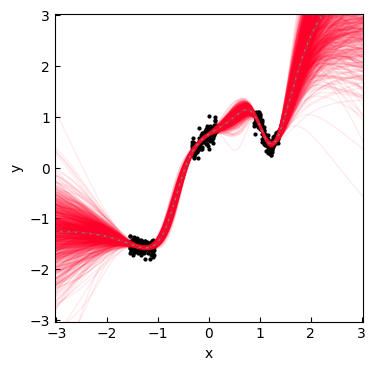

In [3]:
samples_parameters_fs = jax.random.permutation(rng_key_, result.samples["parameters"])
print("samples_parameters_fs.shape", samples_parameters_fs.shape)

n = 2**10
if len(experiment._dataset.conditional_indices) > 1:
    n = 2**4

figure = visualization.RegressionFigure(
    settings=settings.SettingsRegressionFigure(
        settings_plot=settings.SettingsPlot(
            alpha=0.08,
            epistemic=False
        )
    )
)
figure.plot(
    dataset=experiment._dataset,
    transformation=experiment._model_transformation.apply_from_vector,
    parameters_list=[samples_parameters_fs[:n]],
    std=result.samples["std"].mean()
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.96it/s]


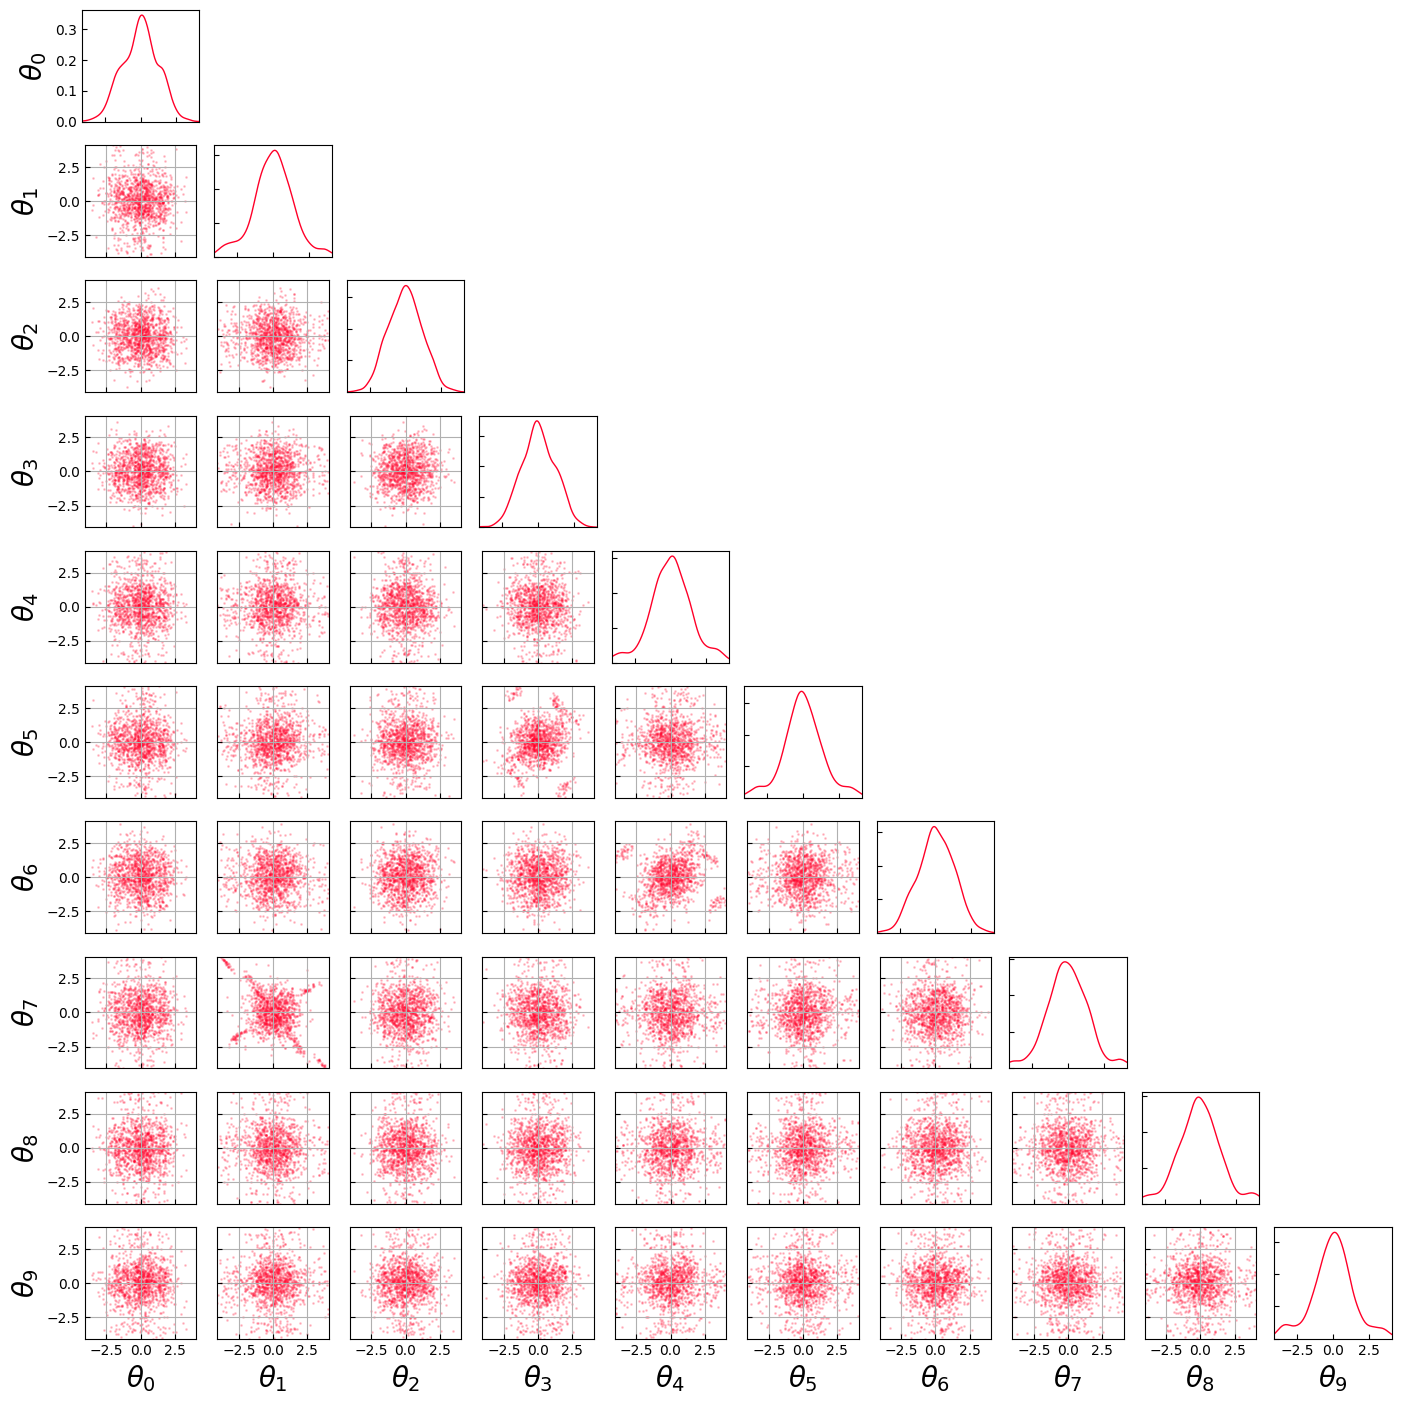

In [5]:
import matplotlib
rng_key, rng_key_ = jax.random.split(rng_key)
samples_parameters_posterior = samples_parameters_fs
#samples_parameters_posterior_gt = result_gt.samples["parameters"]
if samples_parameters_posterior.shape[-1] > 10:
    samples_parameters_posterior = samples_parameters_posterior[:, jax.random.permutation(rng_key_, jnp.arange(samples_parameters_fs.shape[-1]))[:10]]

figure = visualization.TriangleFigure(
    settings=settings.SettingsTriangleFigure(
        prefix=r"\theta",
        settings_scatter=settings.SettingsScatter(
            alpha=0.2,
            size=1.0
        ),
        label_size=20
    )
)
figure.plot(
    data_list=[samples_parameters_posterior,
               #samples_parameters_posterior_gt
              ]
)

In [6]:
figure._figure.savefig(os.path.join(global_settings.PATH_FIGURES, "posterior_full.png"), bbox_inches="tight", dpi=192, transparent=True)

# visualizing layerwise merged marginal posterior distributions

In [7]:
sequential_helper = equioutput.SequentialHelper(
    transformation=experiment._model_transformation,
    dataset=experiment._dataset
)
structured_sequential_samples_parameters = sequential_helper.structured_sequential_samples_parameters(
    samples_parameters=result.samples["parameters"]
)
symmetry_helper = equioutput.SymmetryHelper(structured_sequential_samples_parameters)

In [8]:
subspace_0 = symmetry_helper.hidden_layer_subspace(layer=0)
print(subspace_0.shape)

(1274, 16, 3)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.66it/s]


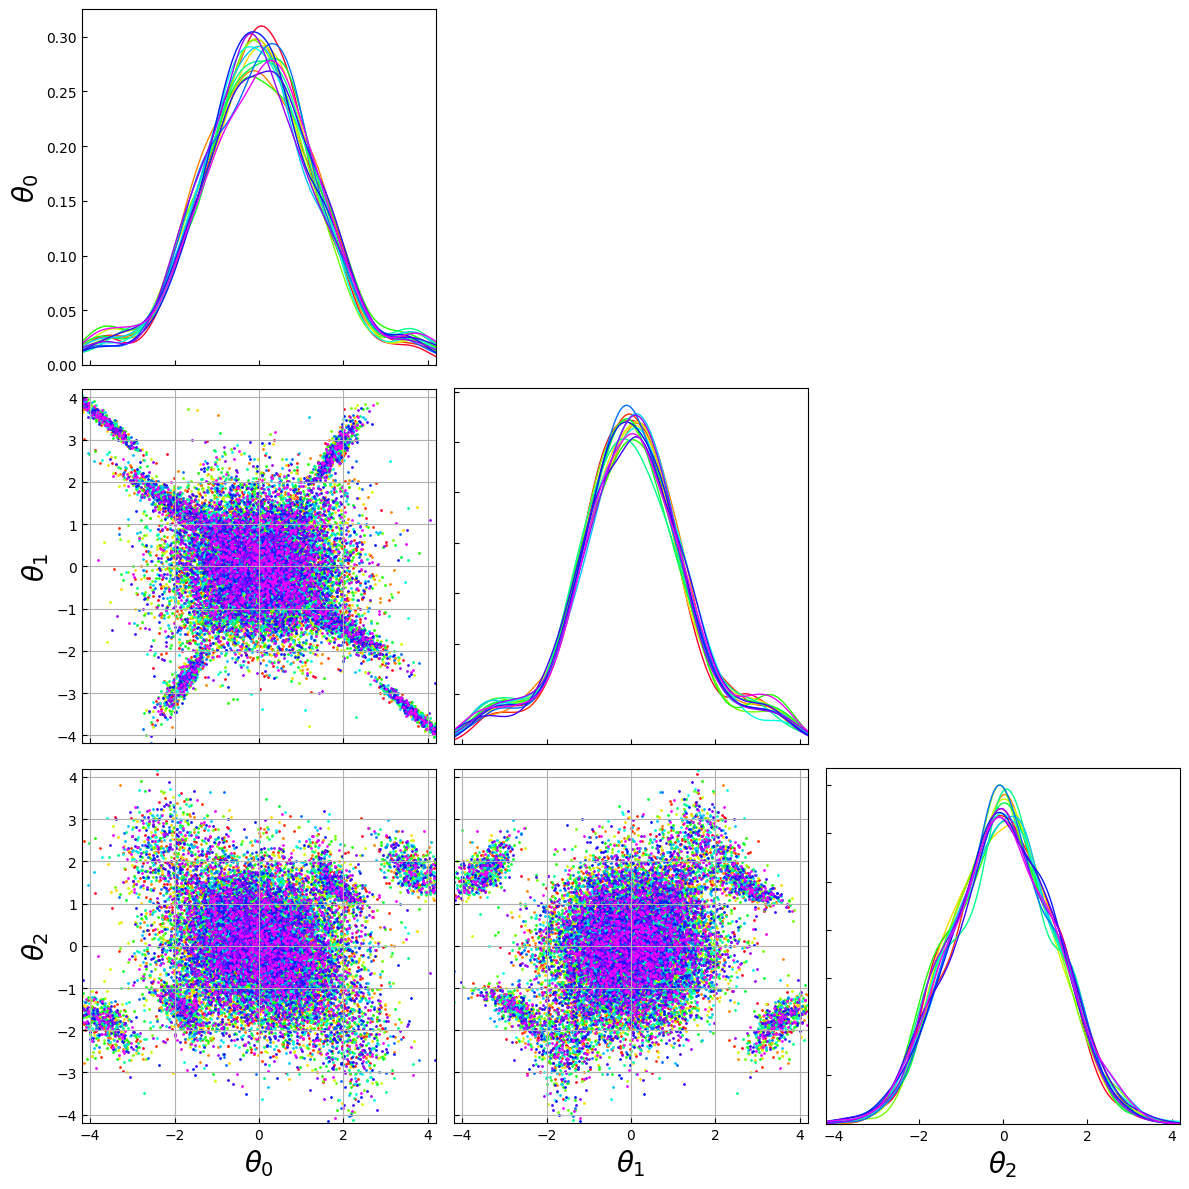

In [9]:
data_list = list(subspace_0.transpose(1, 0, 2))

figure = visualization.TriangleFigure(
    settings=settings.SettingsTriangleFigure(
        ax_width=4.0,
        ax_height=4.0,
        prefix=r"\theta",
        settings_scatter=settings.SettingsScatter(
            alpha=1.0,
            size=1.0
        ),
        label_size=20
    )
)
figure.plot(
    data_list=data_list
)

In [10]:
figure._figure.savefig(os.path.join(global_settings.PATH_FIGURES, "neuron_subspace_merged.png"), bbox_inches="tight", dpi=192, transparent=True)

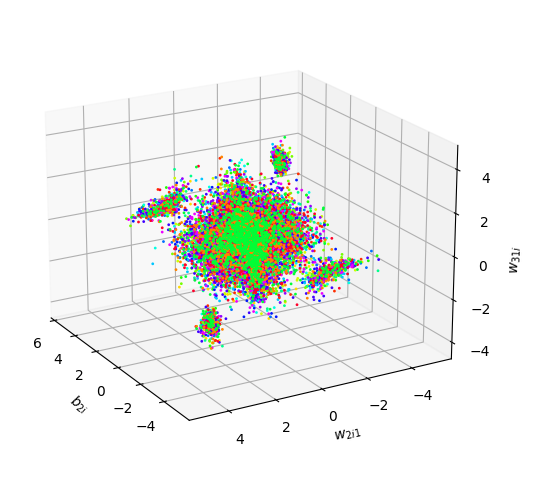

In [11]:
import matplotlib.pyplot as plt
import matplotlib
cmap = matplotlib.cm.get_cmap("gist_rainbow")

figure = plt.figure(figsize=(6, 6))
ax = figure.add_subplot(1, 1, 1, projection="3d")
for h in range(subspace_0.shape[-2]):
    color = cmap(1.0 * h / subspace_0.shape[-2])
    ax.scatter(subspace_0[:, h, 0], subspace_0[:, h, 1], subspace_0[:, h, 2], alpha=0.99, s=1, color=color, rasterized=True)

#ax.scatter(0, 0, 0, alpha=0.99, s=100, c="black", marker='+')
#sample = 0
#ax.scatter(subspace_0[sample, 2, 0], subspace_0[sample, 2, 1], subspace_0[sample, 2, 2], alpha=0.99, s=100, color=color, marker='o')
#ax.scatter(-subspace_0[sample, 2, 0], -subspace_0[sample, 2, 1], -subspace_0[sample, 2, 2], alpha=0.99, s=100, color=color, marker='o')
#ax.plot(
#    [subspace_0[sample, 2, 0], -subspace_0[sample, 2, 0]],
#    [subspace_0[sample, 2, 1], -subspace_0[sample, 2, 1]],
#    [subspace_0[sample, 2, 2], -subspace_0[sample, 2, 2]], alpha=0.99, color=color)

ax.set_xlabel(r"$b_{2i}$")
ax.set_ylabel(r"$w_{2i1}$")
ax.set_zlabel(r"$w_{31i}$")

#ax.view_init(20, 210)
ax.view_init(20, 150)
figure

In [12]:
#figure.savefig(os.path.join(global_settings.PATH_FIGURES, f"{result.identifier}_neuron_subspace_1.png"), bbox_inches="tight", dpi=96)
#figure.savefig(os.path.join(global_settings.PATH_FIGURES, f"{result.identifier}_neuron_subspace_2.png"), bbox_inches="tight", dpi=96)
#figure.savefig(os.path.join(global_settings.PATH_FIGURES, f"{result.identifier}_neuron_subspace_3.png"), bbox_inches="tight", dpi=96)
#figure.savefig(os.path.join(global_settings.PATH_FIGURES, f"{result.identifier}_neuron_subspace_merged.png"), bbox_inches="tight", dpi=96)

figure.savefig(os.path.join(global_settings.PATH_FIGURES, "neuron_subspace_merged_0.pdf"), bbox_inches="tight", dpi=300, transparent=True)

In [13]:
symmetry_helper.remove_tanh_symmetries(layer=0, tanh_planes=1)

epoch: 0,  loss: 4.370760440826416, normal l2 norm: 1.6944496631622314
epoch: 1,  loss: 4.372424602508545, normal l2 norm: 1.8501417636871338
epoch: 2,  loss: 4.377599716186523, normal l2 norm: 1.87654709815979
epoch: 3,  loss: 4.250916957855225, normal l2 norm: 1.709510326385498
epoch: 4,  loss: 4.278192520141602, normal l2 norm: 1.6669167280197144
epoch: 5,  loss: 4.223486423492432, normal l2 norm: 1.6736749410629272
epoch: 6,  loss: 4.1606059074401855, normal l2 norm: 1.7089402675628662
epoch: 7,  loss: 4.149580478668213, normal l2 norm: 1.6199443340301514
epoch: 8,  loss: 4.153585910797119, normal l2 norm: 1.583577275276184
epoch: 9,  loss: 4.133807182312012, normal l2 norm: 1.6383553743362427
epoch: 10,  loss: 4.1221418380737305, normal l2 norm: 1.615944743156433
epoch: 11,  loss: 4.115266799926758, normal l2 norm: 1.6307916641235352
epoch: 12,  loss: 4.1037516593933105, normal l2 norm: 1.656221866607666
epoch: 13,  loss: 4.105180740356445, normal l2 norm: 1.651366114616394
epoch:

In [14]:
subspace_0 = symmetry_helper.hidden_layer_subspace(layer=0)
print(subspace_0.shape)

(1274, 16, 3)


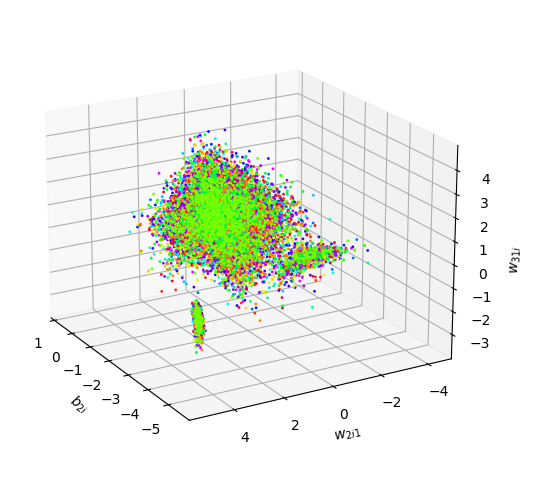

In [15]:
import matplotlib.pyplot as plt
import matplotlib
cmap = matplotlib.cm.get_cmap("gist_rainbow")

figure = plt.figure(figsize=(6, 6))
ax = figure.add_subplot(1, 1, 1, projection="3d")
for h in range(subspace_0.shape[-2]):
    color = cmap(1.0 * h / subspace_0.shape[-2])
    ax.scatter(subspace_0[:, h, 0], subspace_0[:, h, 1], subspace_0[:, h, 2], alpha=0.99, s=1, color=color, rasterized=True)

#ax.scatter(0, 0, 0, alpha=0.99, s=100, c="black", marker='+')
#sample = 0
#ax.scatter(subspace_0[sample, 2, 0], subspace_0[sample, 2, 1], subspace_0[sample, 2, 2], alpha=0.99, s=100, color=color, marker='o')
#ax.scatter(-subspace_0[sample, 2, 0], -subspace_0[sample, 2, 1], -subspace_0[sample, 2, 2], alpha=0.99, s=100, color=color, marker='o')
#ax.plot(
#    [subspace_0[sample, 2, 0], -subspace_0[sample, 2, 0]],
#    [subspace_0[sample, 2, 1], -subspace_0[sample, 2, 1]],
#    [subspace_0[sample, 2, 2], -subspace_0[sample, 2, 2]], alpha=0.99, color=color)

ax.set_xlabel(r"$b_{2i}$")
ax.set_ylabel(r"$w_{2i1}$")
ax.set_zlabel(r"$w_{31i}$")

#ax.view_init(30, 30)
ax.view_init(20, 150)
figure

In [16]:
#figure.savefig(os.path.join(global_settings.PATH_FIGURES, f"{result.identifier}_neuron_subspace_1.png"), bbox_inches="tight", dpi=96)
#figure.savefig(os.path.join(global_settings.PATH_FIGURES, f"{result.identifier}_neuron_subspace_2.png"), bbox_inches="tight", dpi=96)
#figure.savefig(os.path.join(global_settings.PATH_FIGURES, f"{result.identifier}_neuron_subspace_3.png"), bbox_inches="tight", dpi=96)
#figure.savefig(os.path.join(global_settings.PATH_FIGURES, f"{result.identifier}_neuron_subspace_merged.png"), bbox_inches="tight", dpi=96)

figure.savefig(os.path.join(global_settings.PATH_FIGURES, "neuron_subspace_merged_1.pdf"), bbox_inches="tight", dpi=300, transparent=True)

In [17]:
symmetry_helper.remove_permutation_symmetries(layer=0, iterations=256, similarity_matrix="rbf", k=1024)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20384/20384 [03:16<00:00, 103.92it/s]


0 19111
1 14986
2 9837
3 6805
4 4994
5 3990
6 3247
7 2684
8 2187
9 1813
10 1618
11 1476
12 1347
13 1250
14 1178
15 1111
16 1027
17 988
18 957
19 922
20 940
21 892
22 971
23 954
24 908
25 835
26 855
27 814
28 776
29 768
30 726
31 627
32 593
33 552
34 564
35 565
36 527
37 530
38 506
39 462
40 485
41 464
42 480
43 436
44 451
45 449
46 423
47 411
48 393
49 333
50 315
51 334
52 323
53 311
54 303
55 353
56 310
57 317
58 286
59 285
60 289
61 264
62 269
63 265
64 231
65 212
66 229
67 233
68 204
69 228
70 192
71 186
72 181
73 175
74 153
75 159
76 162
77 166
78 150
79 149
80 173
81 162
82 147
83 152
84 156
85 140
86 137
87 169
88 128
89 129
90 148
91 134
92 138
93 141
94 157
95 158
96 135
97 132
98 110
99 118
100 140
101 135
102 148
103 155
104 142
105 133
106 132
107 125
108 94
109 97
110 109
111 104
112 103
113 109
114 100
115 100
116 89
117 98
118 94
119 109
120 102
121 97
122 110
123 104
124 113
125 109
126 107
127 99
128 100
129 93
130 122
131 108
132 108
133 110
134 126
135 118
136 98
137 

{0: array([[-0.8090114 , -0.40607244, -1.0765121 , ...,  3.2056181 ,
         -1.17151   ,  0.23447472],
        [-0.70392674, -0.46453395, -4.2365913 , ..., -0.07384006,
          2.2011962 , -2.135563  ],
        [-0.82448256,  0.1889737 , -2.2926579 , ..., -1.0120319 ,
          1.3090271 ,  0.71924996],
        ...,
        [-0.22358456, -2.1730833 , -1.6951803 , ..., -0.45378312,
          0.554937  , -1.9300344 ],
        [-1.3455755 , -2.8695474 , -0.96472627, ...,  0.04974977,
          1.8255552 ,  3.2089581 ],
        [-1.052808  , -3.974847  , -0.6222823 , ...,  0.8758741 ,
          0.3795297 , -0.34797755]], dtype=float32),
 1: array([[-0.8090114 , -0.40607244, -1.0765121 , ...,  3.2056181 ,
         -1.17151   ,  0.23447472],
        [-0.70392674, -0.590923  , -0.30848193, ...,  2.2011962 ,
         -2.135563  , -0.21845147],
        [-0.82448256,  0.1889737 , -2.2926579 , ..., -1.0120319 ,
          1.3090271 ,  0.71924996],
        ...,
        [-0.22358456, -2.1730833 

In [20]:
subspace_0 = symmetry_helper.hidden_layer_subspace(layer=0)
print(subspace_0.shape)

(1274, 16, 3)


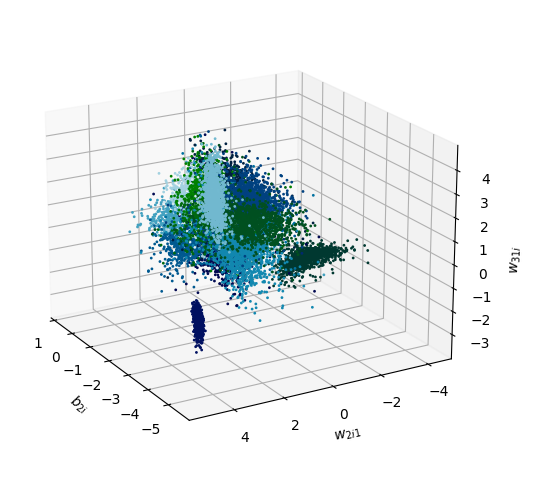

In [41]:
import matplotlib.pyplot as plt
import matplotlib
cmap = matplotlib.cm.get_cmap("ocean")

figure = plt.figure(figsize=(6, 6))
ax = figure.add_subplot(1, 1, 1, projection="3d")
for h in range(subspace_0.shape[-2]):
    color = cmap(1.0 * h / subspace_0.shape[-2])
    ax.scatter(subspace_0[:, h, 0], subspace_0[:, h, 1], subspace_0[:, h, 2], alpha=0.99, s=1, color=color, rasterized=True)

#ax.scatter(0, 0, 0, alpha=0.99, s=100, c="black", marker='+')
#sample = 0
#ax.scatter(subspace_0[sample, 2, 0], subspace_0[sample, 2, 1], subspace_0[sample, 2, 2], alpha=0.99, s=100, color=color, marker='o')
#ax.scatter(-subspace_0[sample, 2, 0], -subspace_0[sample, 2, 1], -subspace_0[sample, 2, 2], alpha=0.99, s=100, color=color, marker='o')
#ax.plot(
#    [subspace_0[sample, 2, 0], -subspace_0[sample, 2, 0]],
#    [subspace_0[sample, 2, 1], -subspace_0[sample, 2, 1]],
#    [subspace_0[sample, 2, 2], -subspace_0[sample, 2, 2]], alpha=0.99, color=color)

ax.set_xlabel(r"$b_{2i}$")
ax.set_ylabel(r"$w_{2i1}$")
ax.set_zlabel(r"$w_{31i}$")

#ax.view_init(30, 30)
ax.view_init(20, 150)
figure

In [19]:
#figure.savefig(os.path.join(global_settings.PATH_FIGURES, f"{result.identifier}_neuron_subspace_1.png"), bbox_inches="tight", dpi=96)
#figure.savefig(os.path.join(global_settings.PATH_FIGURES, f"{result.identifier}_neuron_subspace_2.png"), bbox_inches="tight", dpi=96)
#figure.savefig(os.path.join(global_settings.PATH_FIGURES, f"{result.identifier}_neuron_subspace_3.png"), bbox_inches="tight", dpi=96)
#figure.savefig(os.path.join(global_settings.PATH_FIGURES, f"{result.identifier}_neuron_subspace_merged.png"), bbox_inches="tight", dpi=96)

figure.savefig(os.path.join(global_settings.PATH_FIGURES, "neuron_subspace_merged_2.pdf"), bbox_inches="tight", dpi=300, transparent=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.37it/s]


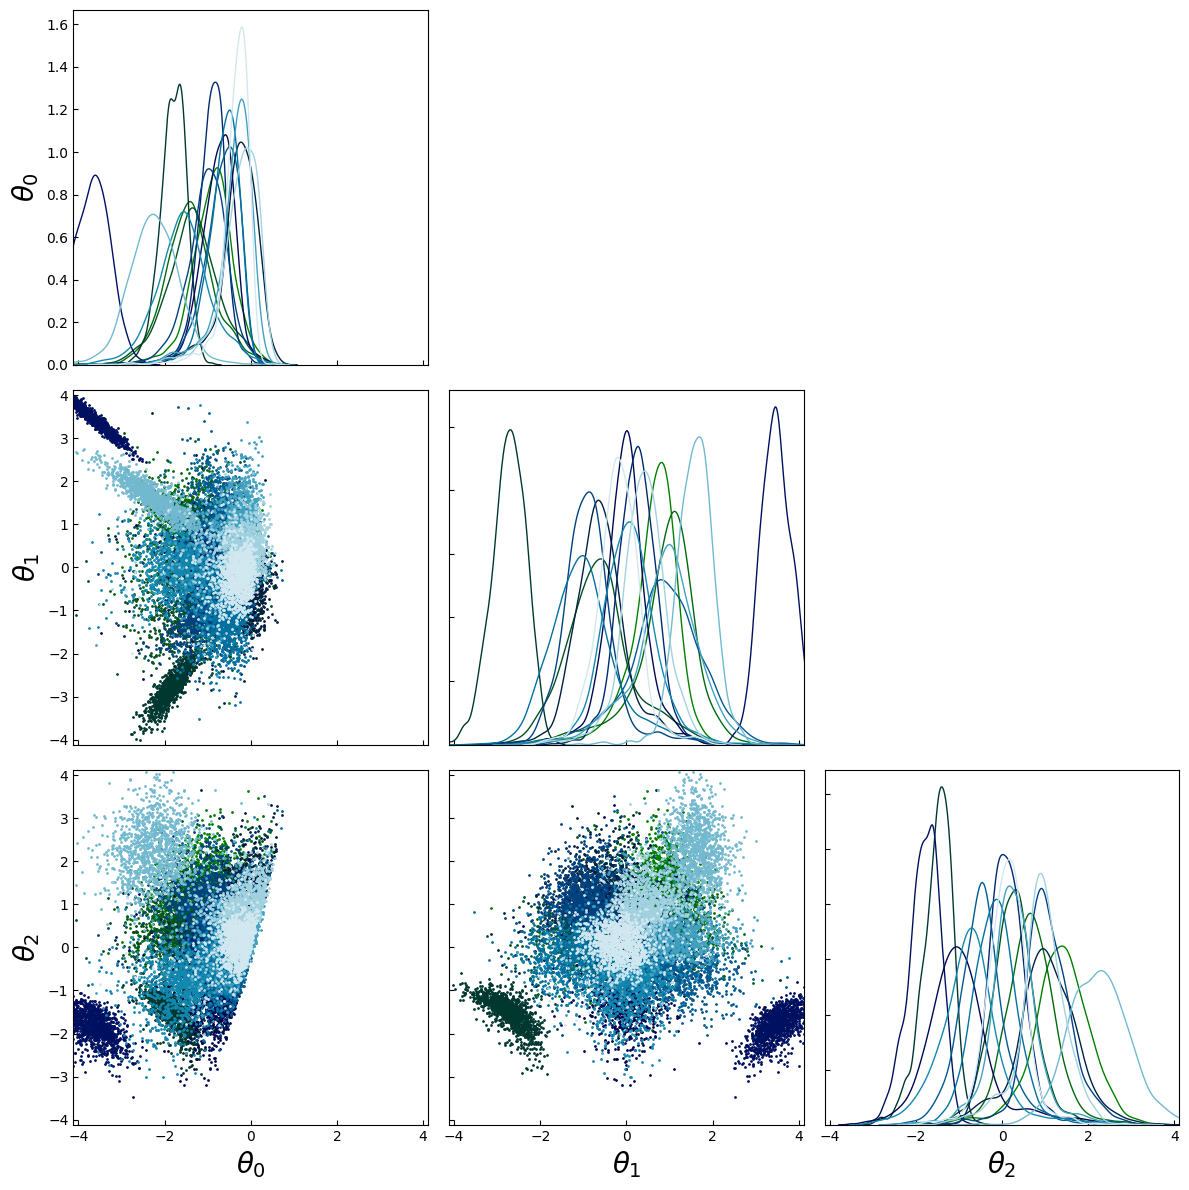

In [40]:
data_list = list(subspace_0.transpose(1, 0, 2))

figure = visualization.TriangleFigure(
    settings=settings.SettingsTriangleFigure(
        ax_width=4.0,
        ax_height=4.0,
        prefix=r"\theta",
        settings_scatter=settings.SettingsScatter(
            alpha=1.0,
            size=1.0
        ),
        label_size=20,
        cmap=matplotlib.cm.get_cmap("ocean") # cubehelix, ocean
    )
)
figure.plot(
    data_list=data_list
)

In [54]:
data_list = list(subspace_0.transpose(1, 0, 2))

figure = visualization.PaperFigureBivariate(
    settings=settings.SettingsPaperFigureBivariate(
        ax_width=4.0,
        ax_height=4.0,
        prefix=r"\theta",
        settings_scatter=settings.SettingsScatter(
            alpha=1.0,
            size=1.0
        ),
        label_size=20,
        cmap=matplotlib.cm.get_cmap("ocean") # cubehelix, ocean
    )
)
figure.plot(
    data_list=data_list
)

[autoreload of visualization failed: Traceback (most recent call last):
  File "/home/gw/data/binaries/mt/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/home/gw/data/binaries/mt/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 455, in superreload
    module = reload(module)
  File "/usr/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/home/gw/documents/master/master_thesis/code/src/visualization/__init__.py", line 11, in <module>
    from .paper_figure_bivariate import PaperFigureBivariate
  File "/home/gw/documents/master/master_thesis/code/src/visualization/paper_figure_bivariate.py", line 13, in <module>
    class

AttributeError: module 'visualization' has no attribute 'PaperFigureBivariate'

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:32<00:00,  1.49it/s]


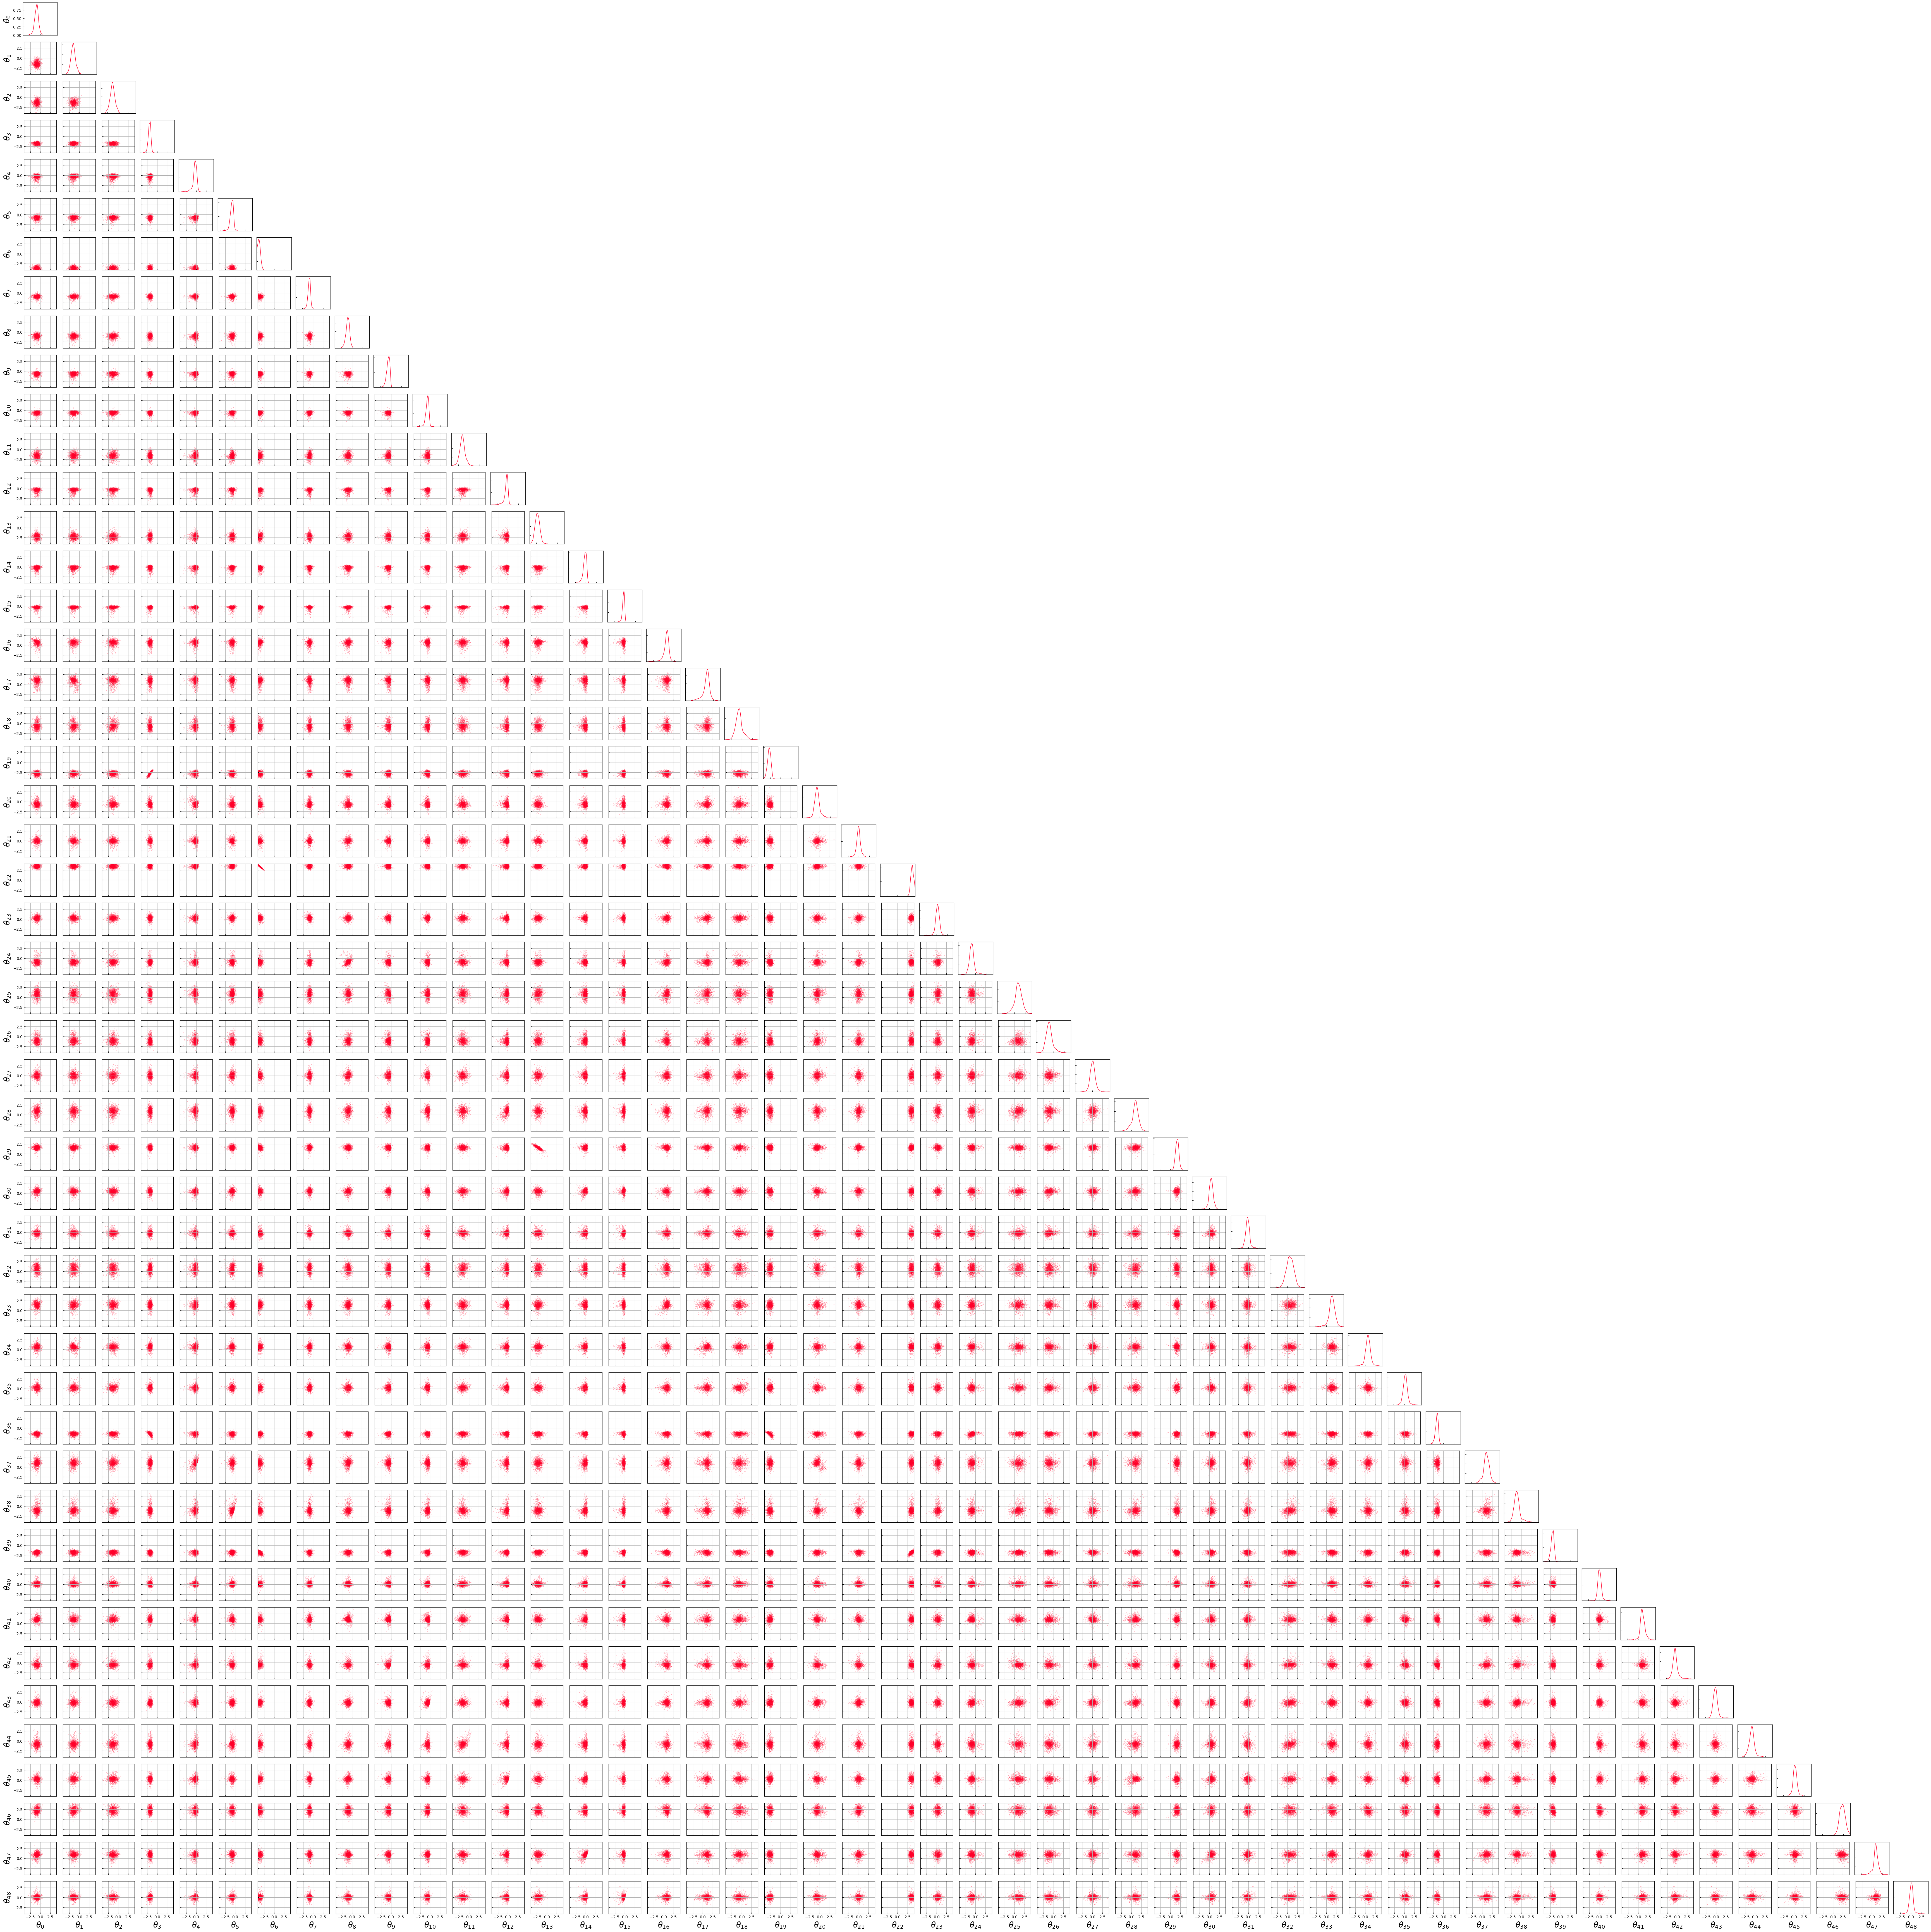

In [22]:
figure = visualization.TriangleFigure(
    settings=settings.SettingsTriangleFigure(
        prefix=r"\theta",
        settings_scatter=settings.SettingsScatter(
            alpha=0.2,
            size=1.0
        ),
        label_size=20
    )
)
figure.plot(
    data_list=[
        structured_sequential_samples_parameters.samples_parameters
    ]
)